# ToF utilities

## Overview
Idea of this notebook is to have a sot of common testing/troubleshooting and calibrating tools for Misty's ToFs in one place, make them easily usable and sharable with Misty users.

## Subscribe to Web Sockets get Data + Almost real-time analysis

Let's get ToF data from the Robot and analyze it almost real-time.
For this we are going to use external lib _**misty_wc.py**_

### How to include:

<code>import os</code><br/>
<code>import sys</code><br/>
<code>sys.path.insert(0, os.getcwd())</code><br/>
<code>from misty_wc import MistyEventInequality, EventCondition, MistyWsEvent, MistyWebClient</code>

### How to use:

- define callback<br>
<code>def onMsg(msg):</code><br>
<code>    print(msg)</code>
<br/><br/>
- define Event Condition:<br>
<code>ec = EventCondition("SensorPosition", MistyEventInequality.Equal, "Right")</code>
<br/><br/>
- define Event:<br>
<code>tofrrEvent = MistyWsEvent("TimeOfFlight", "tof_r_r", 1000, [ec], onMsg)</code>
<br/><br/>
- define Misty Web Client<br>
<code>mwc = MistyWebClient("169.254.206.171")</code>
<br/><br/>
- using of the rest API commands:<br>
<code>mwc.post("led", json={"red":0, "green": 0, "blue": 250})</code>
<br/><br/>
- to make client start listening:<br>
<code>mwc.startListen()</code>
<br/><br/>
- to add event to listen to (this could be done before or after mwc.startListen() is called) :<br>
<code>mwc.addEvent(tofrrEvent)</code>
<br/><br/>
- remove event from the subscribers list, i.e. no more callback on this event:<br>
<code>mwc.removeEvent(tofrrEvent)</code>
<br/><br/>
- to make client stop listening:<br>
<code>mwc.stopListen()</code>
<br/><br/>



### Example:

In [8]:
import os
import sys  

sys.path.insert(0, os.getcwd())
from misty_wc import MistyEventInequality, EventCondition, MistyWsEvent, MistyWebClient
        
# Test example:
from time import sleep

_cnt = -1
test_ip = "10.0.0.194"

def test_onMsg(msg):
    global _cnt
    print(msg)
    print("_"*80)
    _cnt += 1
    row = {}
    row["id"] = _cnt
    row["SensorId"] = msg["message"]["sensorId"]
    row["Time"] = msg["message"]["created"]
    row["Distance"] = msg["message"]["distanceInMeters"]
    row["Status"] = msg["message"]["status"]
    row["AvgTime"] = msg["message"]["averageTimeMs"]
    row["Sigma"] = msg["message"]["sigma"]
    row["Signal"] = msg["message"]["signal"]
    print(row)
    print("_"*80)

test_ec = EventCondition("SensorPosition", MistyEventInequality.Equal, "Right")
test_tofrrEvent = MistyWsEvent("TimeOfFlight", "tof_r_r", 1000, [test_ec], test_onMsg)

test_mwc = MistyWebClient(test_ip)
test_mwc.post("led", json={"red":0, "green": 0, "blue": 250})
test_mwc.startListen()
test_mwc.addEvent(test_tofrrEvent)
test_mwc.post("led", json={"red":0, "green": 127, "blue": 0})

#wait to collect data, or do other stuff "in parallel 
sleep(5)

test_mwc.post("led", json={"red":250, "green": 0, "blue": 0})
test_mwc.removeEvent(test_tofrrEvent)
test_mwc.stopListen()
test_mwc.post("led", json={"red":0, "green": 0, "blue": 250})

test_mwc = None

Websocket thread started
{'eventName': 'tof_r_r', 'message': {'averageTimeMs': 80, 'created': '2019-12-09T23:42:31.8915204Z', 'distanceInMeters': 0.287, 'sensorId': 'toffr', 'sensorPosition': 'Right', 'sigma': 6, 'signal': 19344, 'status': 0, 'type': 'Range'}}
________________________________________________________________________________
{'id': 0, 'SensorId': 'toffr', 'Time': '2019-12-09T23:42:31.8915204Z', 'Distance': 0.287, 'Status': 0, 'AvgTime': 80, 'Sigma': 6, 'Signal': 19344}
________________________________________________________________________________
{'eventName': 'tof_r_r', 'message': {'averageTimeMs': 80, 'created': '2019-12-09T23:42:33.1166741Z', 'distanceInMeters': 0.288, 'sensorId': 'toffr', 'sensorPosition': 'Right', 'sigma': 6, 'signal': 19240, 'status': 0, 'type': 'Range'}}
________________________________________________________________________________
{'id': 1, 'SensorId': 'toffr', 'Time': '2019-12-09T23:42:33.1166741Z', 'Distance': 0.288, 'Status': 0, 'AvgTime':

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, clear_output

_cnt = 0

class Charting:
    
    def __init__(self, fig, pointsNum = 20):
        self.fig = fig
        self.fig.my_ax = self.fig.add_subplot(1,1,1)
        self.fig.show()
        self.fig.canvas.draw()
        self.tofs = pd.DataFrame(columns=["id", "SensorId", "Time",
                                "Distance", "Status", "AvgTime", "Sigma", "Signal"])
        self.cnt = 0
        self.PointsNum = pointsNum

    def parseTofMsg(self, msgParsed = {}):
        global _cnt
        _cnt += 1

        row = {}
        row["id"] = _cnt
        row["SensorId"] = msgParsed["message"]["sensorId"]
        row["Time"] = pd.to_datetime(msgParsed["message"]["created"])
        row["Distance"] = msgParsed["message"]["distanceInMeters"]
        row["Status"] = msgParsed["message"]["status"]
        row["AvgTime"] = msgParsed["message"]["averageTimeMs"]
        row["Sigma"] = msgParsed["message"]["sigma"]
        row["Signal"] = msgParsed["message"]["signal"]
        return pd.DataFrame(row, columns=["id", "SensorId", "Time", "Distance", "Status", "AvgTime", "Sigma", "Signal"], index=[row["id"]])

    def updateLine(self, lastN = 20):
        ppp = self.tofs.tail(lastN).loc[:,["id", "Distance", "Sigma","Signal"]]
        self.fig.my_ax.cla()
        #self.fig.ax.plot(ppp["id"], ppp["Distance"], ppp["Sigma"],ppp["Signal"])
        self.fig.my_ax.plot( ppp["id"], ppp["Distance"])
        #self.fig.canvas.draw()
        display(self.fig)
        clear_output(wait = True)
        plt.pause(0.9)

        #self.fig.canvas.draw()
        #self.fig.my_ax.plot( ppp["id"], ppp["Sigma"]) 
        #self.fig.canvas.draw()
        #self.fig.my_ax.plot( ppp["id"], ppp["Signal"])
        #self.fig.canvas.draw()

    def addMsgToDF(self, msg):
        self.cnt += 1
        x1 = self.parseTofMsg(msg)
        if x1 is None: return None
        self.tofs = pd.concat([self.tofs, x1])
        if self.cnt % self.PointsNum : 
            self.updateLine(self.PointsNum)
        

In [3]:
import os
import sys  
sys.path.insert(0, os.getcwd())
from misty_wc import MistyEventInequality, EventCondition, MistyWsEvent, MistyWebClient
from time import sleep

#robotIP = "169.254.206.171"
robotIP = "10.0.0.194"
_cnt = -1
fig1 = plt.figure()
plt.ion()

ch = Charting(fig1)

ec = EventCondition("SensorPosition", MistyEventInequality.Equal, "Right")
tofrrEvent = MistyWsEvent("TimeOfFlight", "tof_r_r", 100, [ec], ch.addMsgToDF)

mwc = MistyWebClient(robotIP)
mwc.addEvent(tofrrEvent)
mwc.startListen()
mwc.post("led", json={"red":0, "green": 127, "blue": 0})
sleep(240)
ch.updateLine( len(ch.tofs))
mwc.stopListen()
mwc.post("led", json={"red":0, "green": 0, "blue": 250})


<Response [200]>

In [9]:
#run this if some error has happened in cell above and events have not stopped comming
mwc.stopListen()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 238
Data columns (total 9 columns):
id          239 non-null object
SensorId    239 non-null object
Time        239 non-null object
Distance    239 non-null float64
Status      239 non-null object
AvgTime     239 non-null object
Sigma       239 non-null object
Signal      239 non-null object
Error       239 non-null float64
dtypes: float64(2), object(7)
memory usage: 12.1+ KB
None
________________________________________________________________________________
count    239.000000
mean       0.286452
std        0.001027
min        0.284000
25%        0.286000
50%        0.287000
75%        0.287000
max        0.289000
Name: Distance, dtype: float64
________________________________________________________________________________
count    239.000000
mean      -0.000048
std        0.001027
min       -0.002500
25%       -0.000500
50%        0.000500
75%        0.000500
max        0.002500
Name: Error, dtype: float64


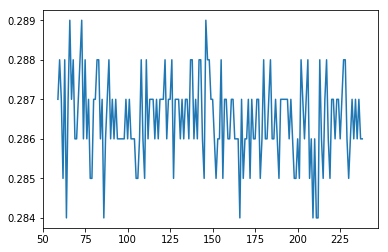

In [5]:
realDistance = 0.2865
ch.tofs["Error"] = ch.tofs["Distance"] -  realDistance

print(ch.tofs.info())
print("_"*80)
print(ch.tofs["Distance"].describe()) 
print("_"*80)
print(ch.tofs["Error"].describe())


ch.updateLine(180)


## Work with ROI + Signal & Sigma Thresholds
### Configure "Runtime" ROI + Signal & Sigma Thresholds
### Restore Saved "Runtime" ROI + Signal & Sigma Thresholds
### Save current to EEPROM, Get Saved  ROI + Signal & Sigma Thresholds


In [1]:
plt.show()
ws.fig.show()
ws.fig.canvas.draw()

    
ppp = ws.tofs.tail(20).loc[:,["id", "Distance", "Sigma","Signal"]]
print( ppp)
ws.fig.ax.plot( [ppp["id"], ppp["Distance"]] , [ppp["id"], ppp["Sigma"]] , [ppp["id"], ppp["Signal"]])
ws.fig.canvas.draw()

##
#fig = plt.figure()
#ax = fig.subplots()
#plt.ion()
#fig.show()
#fig.canvas.draw()

#print(tofs.loc[:,["id","Distance"]]) 
#help(ax.plot)

#ax.clear()
#ax.plot(tofs.loc[:20,["id"]], tofs.loc[:20,["Distance"]])
#ax.plot(ppp["id"], ppp["Distance"])

#fig.canvas.draw()


NameError: name 'plt' is not defined

## Calibration
### Calibrate Offset
### Calibrate Crosstalk
### Reset to default settings
